# Perlin noise

_Gilbert François Duivesteijn_


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from IPython.core.display import display, HTML # my imports

In [2]:
%matplotlib inline

## 1D Perlin noise

Exploration between 2 grid points.

In [3]:
# Number of cells
nx = 4

# Random gradients at grid points with range [-1,1]
grad = 2*np.random.rand(nx+1)-1

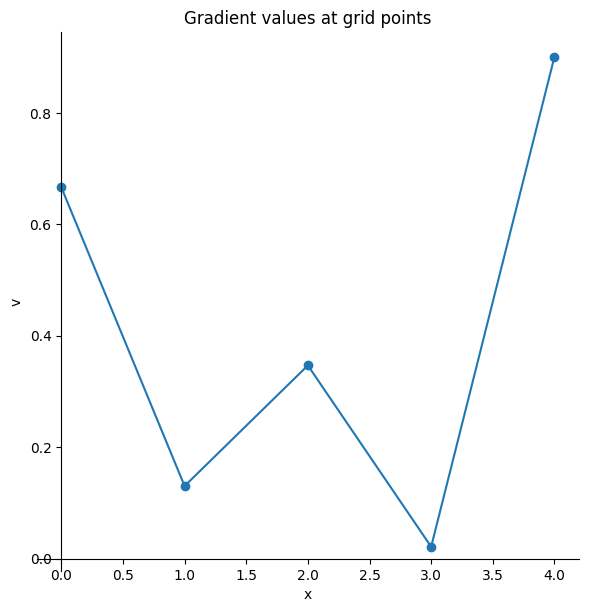

Grad values:
[0.6667044  0.1304668  0.34689969 0.02147021 0.90084119]


In [4]:
plt.figure(figsize=(7, 7))
plt.plot(grad, marker="o")
axs = plt.gca()
axs.spines['left'].set_position('zero')
axs.spines['right'].set_color('none')
axs.spines['bottom'].set_position('zero')
axs.spines['top'].set_color('none')
plt.title("Gradient values at grid points")
plt.xlabel("x")
plt.ylabel("v")
plt.show()
print("Grad values:")
print(grad)

In [5]:
x = np.linspace(0, 1, 101)[:100]

ix0 = np.floor(x).astype("int")
ix1 = ix0 + 1

dx0 = x - ix0
dx1 = x - ix1

dg0 = grad[ix0]*dx0
dg1 = grad[ix1]*dx1

w = x - ix0

z_linear = (dg1 - dg0)*w + dg0
z_cubic  = (dg1 - dg0)*(3.0 - w * 2.0)*w**2 + dg0;

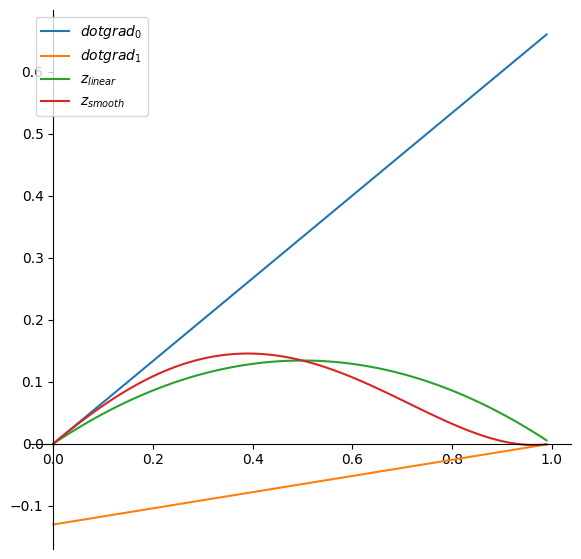

In [6]:
plt.figure(figsize=(7, 7))
plt.plot(x, dg0, label="$dotgrad_0$")
plt.plot(x, dg1, label="$dotgrad_1$")
plt.plot(x, z_linear, label="$z_{linear}$")
plt.plot(x, z_cubic, label="$z_{smooth}$")

axs = plt.gca()
axs.spines['left'].set_position('zero')
axs.spines['right'].set_color('none')
axs.spines['bottom'].set_position('zero')
axs.spines['top'].set_color('none')
plt.legend()
plt.show()

## 1D Perlin noise functions

In [7]:
def dotgrad(x, ix, grad):
    # distance vector
    dx = x - ix
    # grad times distance
    dz = grad[ix]*dx
    return dz

def lerp(a0, a1, w, interpolation):
    # Linear interpolation
    if interpolation == 0:
        return (a1 - a0)*w + a0
    # Cubic interpolation
    elif interpolation == 1:
        return (a1 - a0) * (3.0 - w * 2.0) * w * w + a0;
    else:
        raise ValueError(f"Invalid interpolation method: {interpolation}")
    
def perlin(x, interpolation):
    
    # Find closest surrounding grid points.
    ix0 = np.floor(x).astype("int")
    ix1 = ix0 + 1
    
    # Compute the value at the grid points, with dot product of grad*dist.
    z0 = dotgrad(x, ix0, grad)
    z1 = dotgrad(x, ix1, grad)
    
    # Interpolate between the values of the 2 surrounding grid points.
    z = lerp(z0, z1, x - ix0, interpolation)

    return z

In [8]:
x = np.linspace(0, nx, nx*100+1)[:-1]

In [9]:
z_linear = perlin(x, interpolation=0)
z_cubic = perlin(x, interpolation=1)

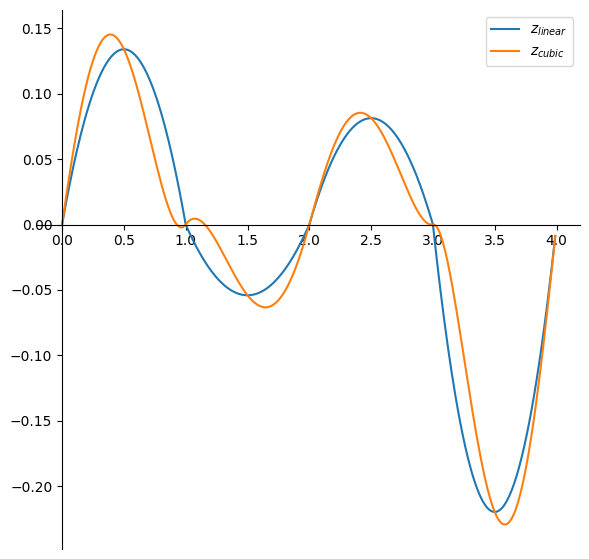

In [10]:
plt.figure(figsize=(7, 7))
plt.plot(x, z_linear, label="$z_{linear}$")
plt.plot(x, z_cubic, label="$z_{cubic}$")

axs = plt.gca()
axs.spines['left'].set_position('zero')
axs.spines['right'].set_color('none')
axs.spines['bottom'].set_position('zero')
axs.spines['top'].set_color('none')
plt.legend()
plt.show()

## 2D Perlin noise functions

Following Ken Perlin's reference implementation [[1](https://mrl.cs.nyu.edu/~perlin/noise/)], this is a vectorized implementation using numpy.


In [11]:
# Define number of grid cells
nx_cells = 4
ny_cells = 4

# Set grid indices
x = np.linspace(0, nx_cells, nx_cells+1)
y = np.linspace(0, ny_cells, ny_cells+1)
xx, yy = np.meshgrid(x, y)

# Create gradient vectors dvdx,dvdy for each grid point.
gradv = 2*np.random.rand(nx_cells+1, ny_cells+1,2)-1

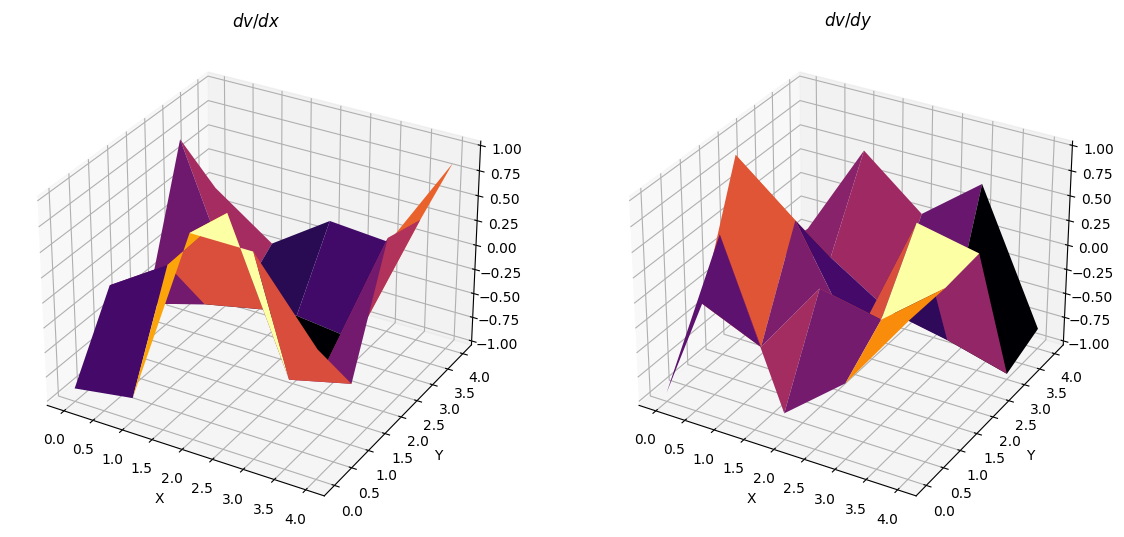

In [12]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(14, 7))
ax[0].plot_surface(xx, yy, gradv[:,:,0], cmap="inferno", linewidth=1, antialiased=True)
ax[1].plot_surface(xx, yy, gradv[:,:,1], cmap="inferno", linewidth=1, antialiased=True)
ax[0].set_zlim(-1, 1)
ax[0].set_title("$dv/dx$")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[1].set_zlim(-1, 1)
ax[1].set_title("$dv/dy$")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.show()

In [13]:
def dotgrad(x, y, x0, y0, gradv):
    dx = x - x0
    dy = y - y0
    return (gradv[x0, y0, 0]*dx + gradv[x0, y0, 1]*dy)

def lerp(v0, v1, w, smooth=True):
    if smooth:
        v = (v1 - v0) * (3.0 - w * 2.0) * w * w + v0;
    else:
        v = (v1-v0)*w + v0
    return v

def perlin(x, y, smooth=True, debug=False):
    
    # Find closest gridpoints on left and right hand side of the point.
    x0 = np.floor(x).astype("int")
    x1 = x0 + 1
    y0 = np.floor(y).astype("int")
    y1 = y0 + 1
    
    # Compute the dot gradients for all gridpoints in the domain
    v00 = dotgrad(x, y, x0, y0, gradv)
    v01 = dotgrad(x, y, x1, y0, gradv)  
    v10 = dotgrad(x, y, x0, y1, gradv)
    v11 = dotgrad(x, y, x1, y1, gradv)
    
    v0x = lerp(v00, v01, x - x0, smooth)
    v1x = lerp(v10, v11, x - x0, smooth)
    vxy = lerp(v0x, v1x, y - y0, smooth)
    if debug:
        return vxy, v00, v01, v10, v11, v0x, v1x
    else:
        return vxy

In [14]:
# Compute the noise within the domain

x = np.linspace(0, nx_cells, nx_cells*10+1)
y = np.linspace(0, ny_cells, ny_cells*10+1)
xx, yy = np.meshgrid(x, y)
xx = xx[:-1,:-1]
yy = yy[:-1,:-1]

zzl = perlin(xx, yy, smooth=False)
zzs = perlin(xx, yy, smooth=True)

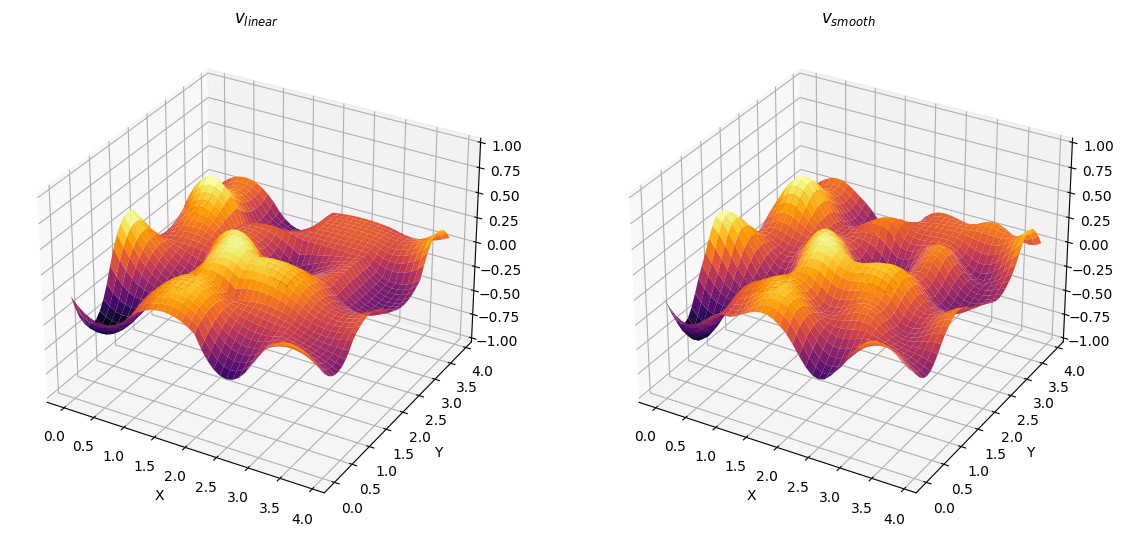

In [15]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(14, 7))
ax[0].plot_surface(xx, yy, zzl, cmap="inferno", linewidth=1, antialiased=True)
ax[0].set_zlim(-1, 1)
ax[0].set_title("$v_{linear}$")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[1].plot_surface(xx, yy, zzs, cmap="inferno", linewidth=1, antialiased=True)
ax[1].set_zlim(-1, 1)
ax[1].set_title("$v_{smooth}$")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.show()

## Unit test for MSX code

In [16]:
# Define number of grid cells
nx_cells = 4
ny_cells = 4

# Offset
ox=0
oy=0

# n_pixels per cell
px = (256-2*ox)/nx_cells
py = (192-2*oy)/ny_cells

print(f"px: {px}")
print(f"py: {py}")

px: 64.0
py: 48.0


In [17]:
# Screen pixels

x = np.arange(0, 256)
y = np.arange(0, 192)

assert x.shape[0] == 256
assert y.shape[0] == 192

print("x = ")
print(x)
print("y = ")
print(y)

x = 
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 2

In [18]:
xp = (x-2*ox)/px
yp = (y-2*oy)/py

assert xp.shape[0] == 256
assert yp.shape[0] == 192

print("xp = ")
print(xp)
print("yp = ")
print(yp)

xp = 
[0.       0.015625 0.03125  0.046875 0.0625   0.078125 0.09375  0.109375
 0.125    0.140625 0.15625  0.171875 0.1875   0.203125 0.21875  0.234375
 0.25     0.265625 0.28125  0.296875 0.3125   0.328125 0.34375  0.359375
 0.375    0.390625 0.40625  0.421875 0.4375   0.453125 0.46875  0.484375
 0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375
 1.       1.015625 1.03125  1.046875 1.0625   1.078125 1.09375  1.109375
 1.125    1.140625 1.15625  1.171875 1.1875   1.203125 1.21875  1.234375
 1.25     1.265625 1.28125  1.296875 1.3125   1.328125 1.34375  1.359375
 1.375    1.390625 1.40625  1.421875 1.4375   1.453125 1.46875  1.484375
 1.5      1.515625 1.53125  1.546875 1.5625   1.578125 1.59375  1.609375
 1.625    1.640625 1.65625  1.671875 1.6875  

In [19]:
# Set grid indices
x = np.linspace(0, nx_cells, nx_cells+1)
y = np.linspace(0, ny_cells, ny_cells+1)
xx, yy = np.meshgrid(x, y)

# Create gradient vectors dvdx,dvdy for each grid point.
gradv_x = np.cos(xx)*np.cos(yy)
gradv_y = np.sin(yy)*np.sin(xx)
gradv = np.stack([gradv_x, gradv_y], axis=2)

# gradv = 2*np.random.rand(nx_cells+1, ny_cells+1,2)-1
# gradv.shape

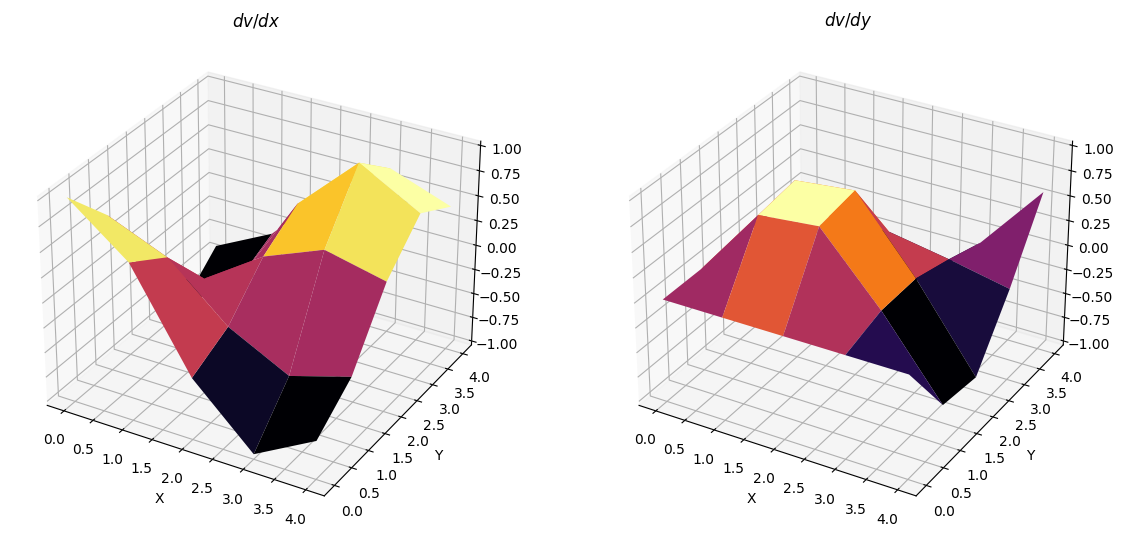

In [20]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(14, 7))
ax[0].plot_surface(xx, yy, gradv[:,:,0], cmap="inferno", linewidth=1, antialiased=True)
ax[1].plot_surface(xx, yy, gradv[:,:,1], cmap="inferno", linewidth=1, antialiased=True)
ax[0].set_zlim(-1, 1)
ax[0].set_title("$dv/dx$")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[1].set_zlim(-1, 1)
ax[1].set_title("$dv/dy$")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.show()


In [21]:
gradv[:,:,0]

array([[ 1.        ,  0.54030231, -0.41614684, -0.9899925 , -0.65364362],
       [ 0.54030231,  0.29192658, -0.2248451 , -0.53489523, -0.35316516],
       [-0.41614684, -0.2248451 ,  0.17317819,  0.41198225,  0.27201173],
       [-0.9899925 , -0.53489523,  0.41198225,  0.98008514,  0.64710228],
       [-0.65364362, -0.35316516,  0.27201173,  0.64710228,  0.42724998]])

In [22]:
gradv[:,:,1]

array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.        ],
       [ 0.        ,  0.70807342,  0.7651474 ,  0.11874839, -0.63682734],
       [ 0.        ,  0.7651474 ,  0.82682181,  0.12832006, -0.68815856],
       [ 0.        ,  0.11874839,  0.12832006,  0.01991486, -0.10679997],
       [-0.        , -0.63682734, -0.68815856, -0.10679997,  0.57275002]])

In [23]:
yy, xx = np.meshgrid(yp, xp)
print(xx.shape, yy.shape)


zzl, v00, v01, v10, v11, v0x, v1x = perlin(xx, yy, smooth=False, debug=True)
zzs, v00, v01, v10, v11, v0x, v1x = perlin(xx, yy, smooth=True, debug=True)

# zzs = perlin(xx, yy, smooth=True)

(256, 192) (256, 192)


In [24]:
_x=100
_y=10

print(v00[_x,_y])
print(v01[_x,_y])
print(v10[_x,_y])
print(v11[_x,_y])
print(v0x[_x,_y])
print(v1x[_x,_y])
print(zzl[_x,_y])
print(zzl.shape)
print(xp.shape)

0.30392004705082865
0.1820642409893748
-0.3963494205787942
-0.507371963421123
0.23162766210714386
-0.46221484516542966
0.09075620675191398
(256, 192)
(256,)


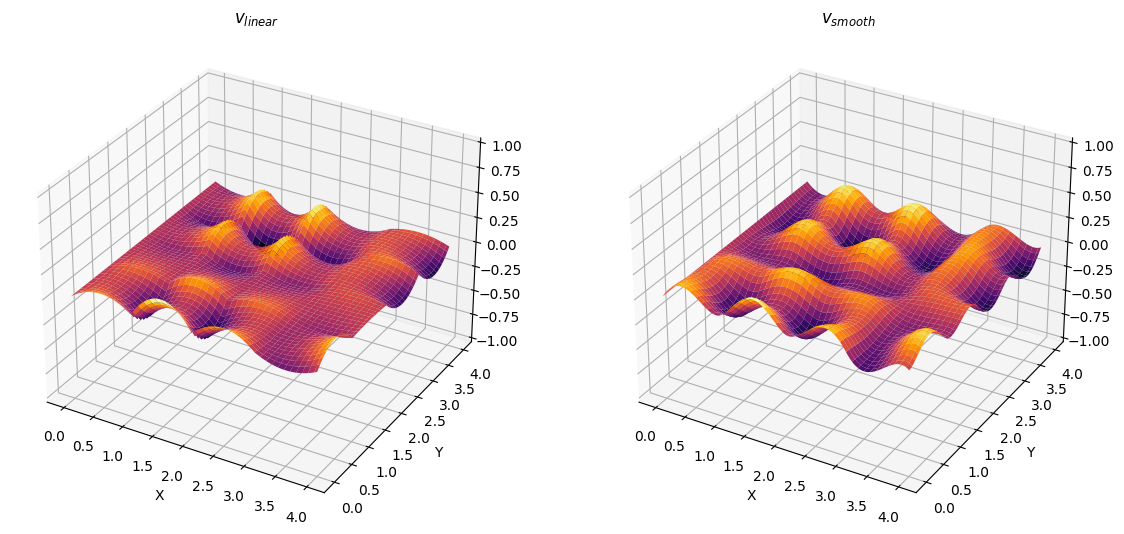

In [25]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(14, 7))
ax[0].plot_surface(xx, yy, zzl, cmap="inferno", linewidth=1, antialiased=True)
ax[0].set_zlim(-1, 1)
ax[0].set_title("$v_{linear}$")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[1].plot_surface(xx, yy, zzs, cmap="inferno", linewidth=1, antialiased=True)
ax[1].set_zlim(-1, 1)
ax[1].set_title("$v_{smooth}$")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.show()

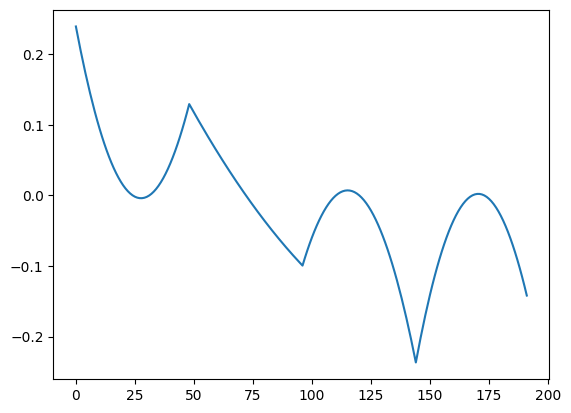

In [26]:
plt.figure()
plt.plot(zzl[96,:])
plt.show()